# Tutorial: Single earthquake liquefaction assessment

The OpenQuake engine now has several models liquefaction assessment and the displacements from liquefaction-induced lateral spreading given the magnitude of an earthquake, the ground shaking parameters in terms of Peak Ground Acceleration (PGA) or Peak Ground Velocity (PGV) at each site, and the susceptibility of each site to liquefaction (which is based on local geotechnical characteristics and a soil wetness variable or proxy). Furthermore, the geospatial models use DEM derived inputs that serve as first-order proxies to characterise the soil density and saturation.

These functions are quite easy to use and the calculations are very rapid.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from openquake.sep.liquefaction import (
    zhu_etal_2015_general,
    zhu_etal_2017_general,
    hazus_liquefaction_probability,
    todorovic_silva_2022_nonparametric_general
)

from openquake.sep.liquefaction.lateral_spreading import (
    hazus_lateral_spreading_displacement
)

In [2]:
sites = pd.read_csv("./tutorial_data/liquefaction_sites.csv")

sites.head()

,lon,lat,unit,dr,susc_cat,gwd,vs30,cti,precip,dc
0,-76.540896,3.350158,TQplp,1.374984,n,3.0,425.0,4.287466,141,74
1,-76.544763,3.350644,TQplp,1.362502,n,3.0,425.0,3.614118,141,74
2,-76.528079,3.346550,TQplp,1.806348,n,3.0,425.0,5.328922,131,75
3,-76.529860,3.356627,TQplp,0.847645,n,3.0,425.0,6.514543,132,74
4,-76.527918,3.351601,TQplp,1.254576,n,3.0,425.0,6.139852,131,75


In [3]:
event_mag = 7.2
event_shaking = pd.read_csv("./tutorial_data/example_pga_pgv.csv")
event_shaking.head(5)

,lon,lat,pga,pgv
0,-76.540896,3.350158,0.321998,33
1,-76.544763,3.350644,0.390889,36
2,-76.528079,3.346550,0.378206,54
3,-76.529860,3.356627,0.410492,43
4,-76.527918,3.351601,0.287797,41


## Liquefaction probabilities using the HAZUS model

The HAZUS model calculates the probabilities of liquefaction given the magnitude and PGA of an earthquake, the liquefaction category of the site, and the depth to groundwater at that site.

In [4]:
hazus_liq_prob = hazus_liquefaction_probability(pga=event_shaking["pga"], mag=event_mag,
                                                liq_susc_cat=sites["susc_cat"],
                                                groundwater_depth=sites["gwd"])

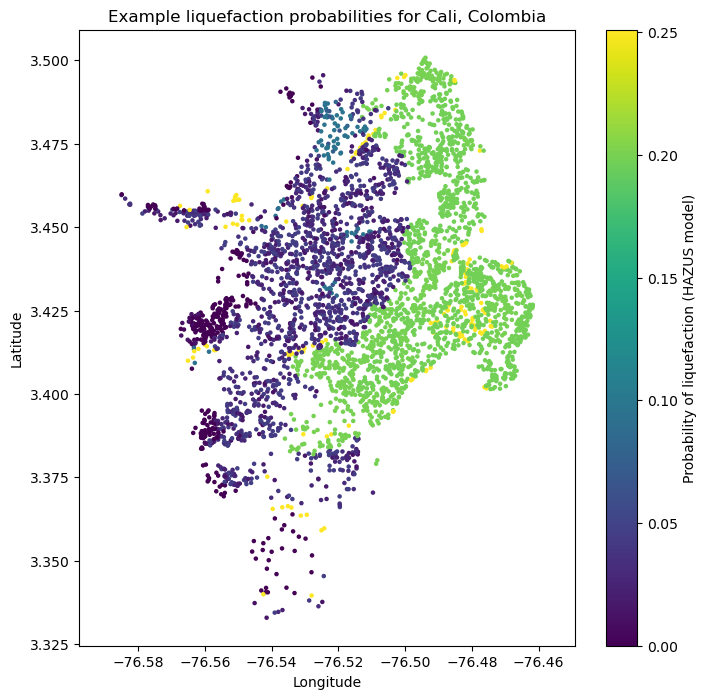

In [5]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(sites.lon, sites.lat, s=5, c=hazus_liq_prob)
plt.colorbar(label='Probability of liquefaction (HAZUS model)')
plt.title('Example liquefaction probabilities for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

## Liquefaction probabilities using the model from Zhu et al. (2015)

The liquefaction probability model by Zhu et al (2015) is based on a multivariate logistic regression. The dependent variables are the magnitude and PGA from an earthquake, and the Vs30 and Compound topographic Index (CTI) at each site.

In [6]:
zhu15_liq_prob = zhu_etal_2015_general(pga=event_shaking["pga"], mag=event_mag, cti=sites["cti"], vs30=sites["vs30"])[0]

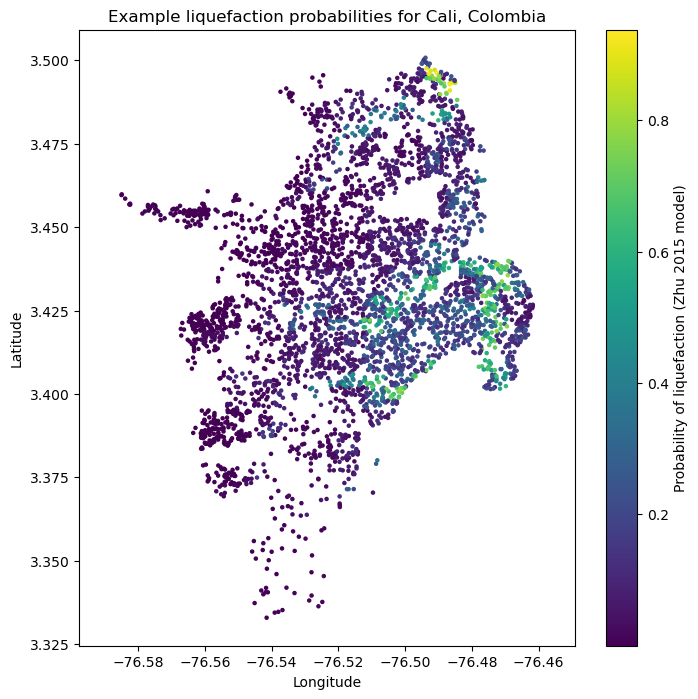

In [7]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(sites.lon, sites.lat, s=5, c=zhu15_liq_prob)
plt.colorbar(label='Probability of liquefaction (Zhu 2015 model)')
plt.title('Example liquefaction probabilities for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

## Liquefaction probabilities using the model from Zhu et al. (2017) general

In [8]:
sites['dw'] = sites[['dr','dc']].min(axis=1)

In [9]:
zhu17_liq_prob = zhu_etal_2017_general(pgv=event_shaking["pgv"], vs30=sites["vs30"], dw=sites["dw"],
                                    precip=sites["precip"], wtd=sites["gwd"])[0]

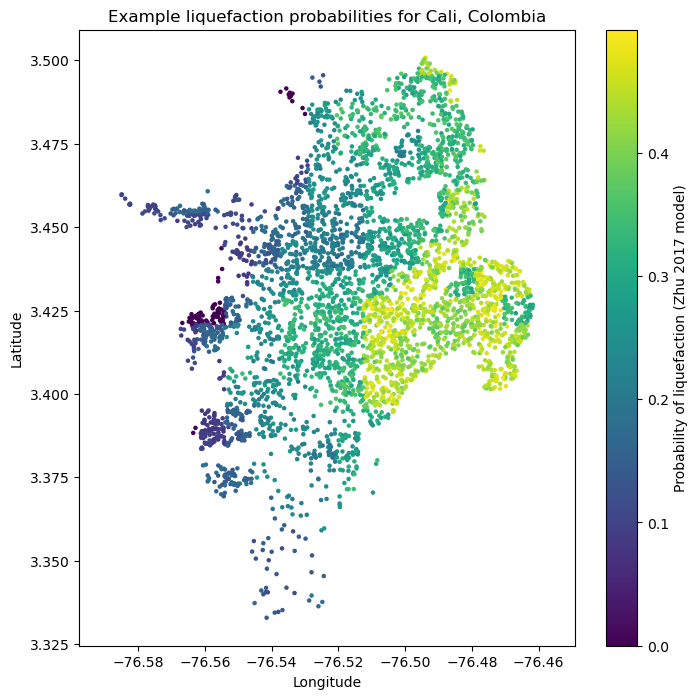

In [10]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(sites.lon, sites.lat, s=5, c=zhu17_liq_prob)
plt.colorbar(label='Probability of liquefaction (Zhu 2017 model)')
plt.title('Example liquefaction probabilities for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

We can also compute the liquefaction spatial extent. After an earthquake LSE is the spatial area covered by surface manifestations of liquefaction reported as a percentage of liquefied material within that pixel.

In [11]:
zhu17_LSE = zhu_etal_2017_general(pgv=event_shaking["pgv"], vs30=sites["vs30"], dw=sites["dw"],
                                    precip=sites["precip"], wtd=sites["gwd"])[2]

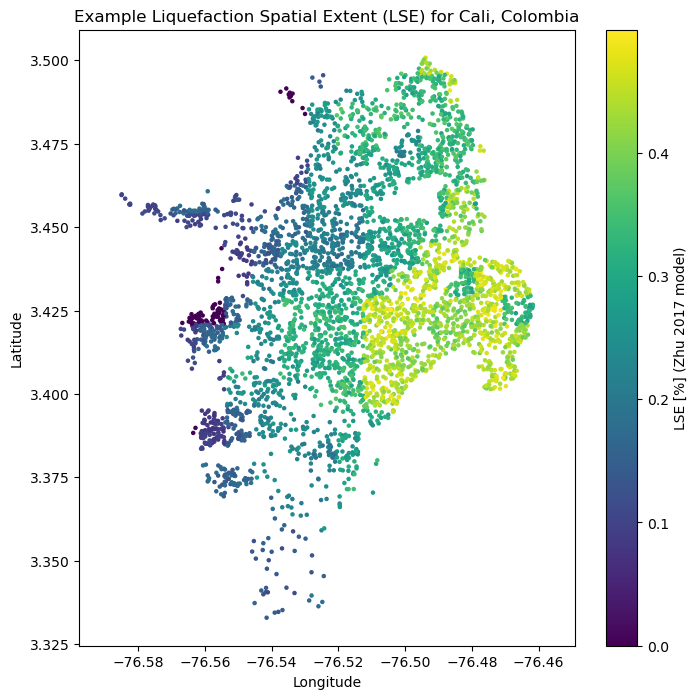

In [12]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(sites.lon, sites.lat, s=5, c=zhu17_liq_prob)
plt.colorbar(label='LSE [%] (Zhu 2017 model)')
plt.title('Example Liquefaction Spatial Extent (LSE) for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

## Liquefaction occurrence using the nonparametric Todorovic_Silva_2022 model

A nonparametric model can be used to predict liquefaction occurrence given the input variables. We identify the optimal variables to be: strain_proxy defined as the ratio between PGV and Vs30, distance to the nearest water body, average precipitation and water table depth

In [13]:
occurrence = todorovic_silva_2022_nonparametric_general(pgv=event_shaking["pgv"], vs30=sites["vs30"], dw=sites["dw"],
                                    precip=sites["precip"], wtd=sites["gwd"])[0]

## Comparison

The liquefaction models here are based on different types of data and were developed quite intependently. It is instructive to compare them.

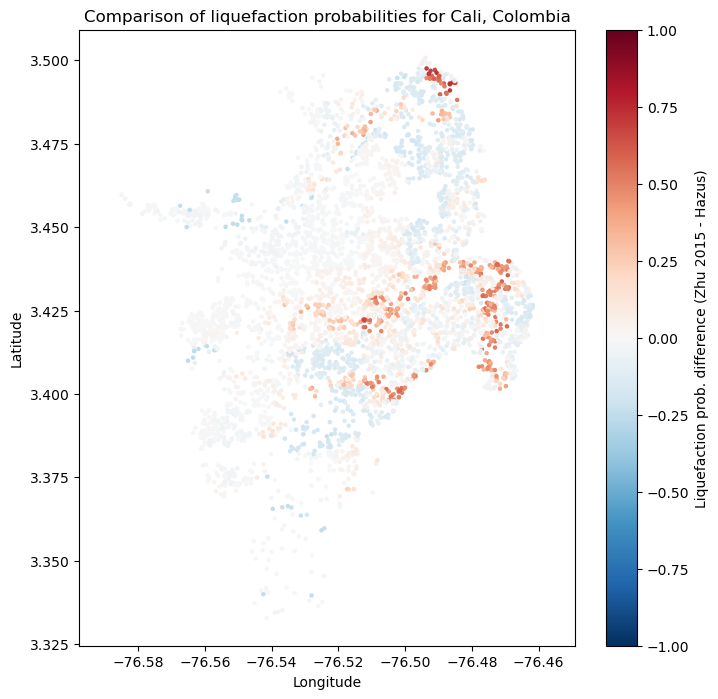

In [14]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(sites.lon, sites.lat, s=5, 
            c=zhu15_liq_prob-hazus_liq_prob,
            vmin=-1., vmax=1.,
            cmap='RdBu_r')
plt.colorbar(label='Liquefaction prob. difference (Zhu 2015 - Hazus)')
plt.title('Comparison of liquefaction probabilities for Cali, Colombia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

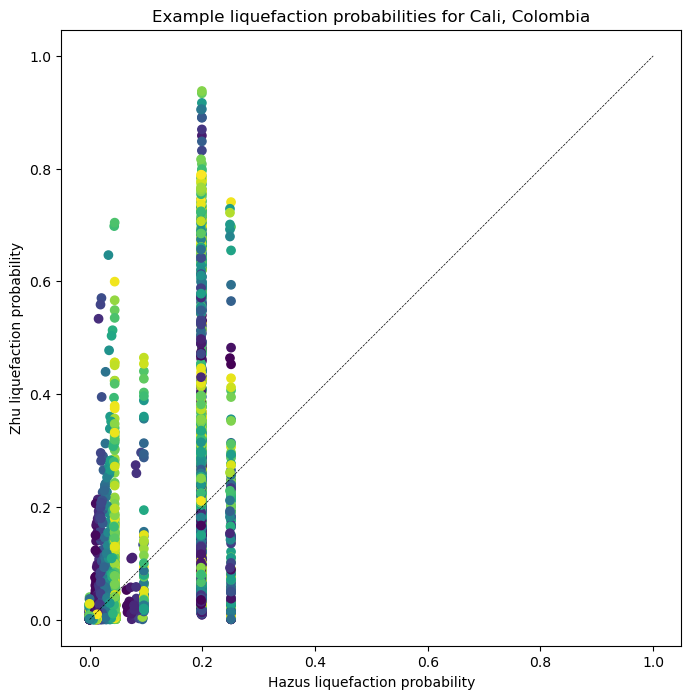

In [15]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(hazus_liq_prob, zhu15_liq_prob, c=event_shaking["pga"])
plt.plot([0,1],[0,1], 'k--', lw=0.5)

plt.title('Example liquefaction probabilities for Cali, Colombia')
plt.xlabel('Hazus liquefaction probability')
plt.ylabel('Zhu liquefaction probability')

plt.show()

It is clear from these plots that the two liquefaction models produce highly discrepant results.  This is a warning that they should be implemented with caution, and calibrated on a local to regional level if at all possible.  Both models may be calibrated by adjusting the coefficents for each variable relating soil strength and wetness to liquefaction. 

Unfortunately, the tools for these calibrations are not implemented in the OpenQuake engine, although the functions used internally in the secondary perils module may accept modified coefficients.

## Lateral spreading displacements

Displacements due to lateral spreading associated with liquefaction can be calculated given the earthquake's PGA, magnitude, and the liquefaction susceptibility of each site. The model currently implemented is from HAZUS.

In [16]:
hazus_displacements = hazus_lateral_spreading_displacement(event_mag, event_shaking["pga"], sites["susc_cat"])

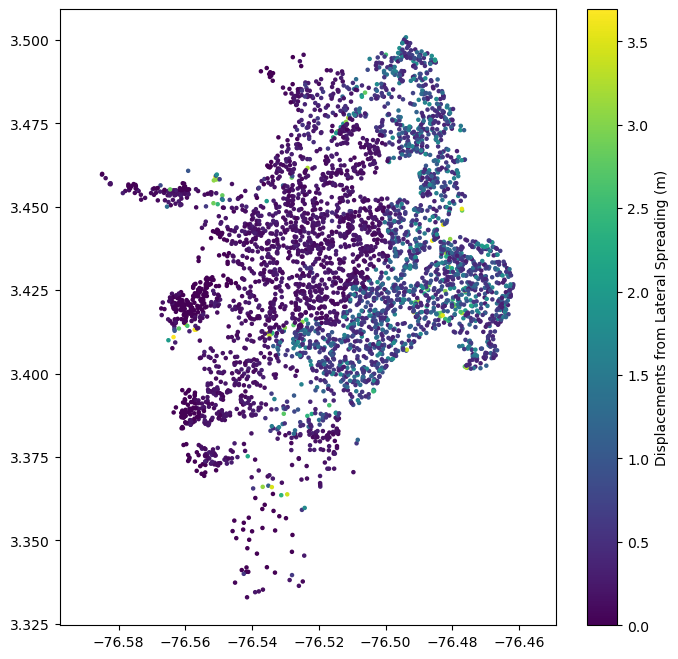

In [17]:
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(sites.lon, sites.lat, s=5, 
            c=hazus_displacements,
            )
plt.colorbar(label='Displacements from Lateral Spreading (m)')
plt.show()